## References:

- https://koalas.readthedocs.io/en/latest/
- https://koalas.readthedocs.io/en/latest/getting_started/videos_blogs.html#data-ai-summit-2020-europe-nov-18-19-2020
- https://databricks.com/blog/2020/03/31/10-minutes-from-pandas-to-koalas-on-apache-spark.html
- https://databricks.com/blog/2020/08/11/interoperability-between-koalas-and-apache-spark.html

## From Pandas to Koalas

In [1]:
import pandas as pd
import numpy as np
import databricks.koalas as ks
from pyspark.sql import SparkSession

In [2]:
dates = pd.date_range('20130101', periods=6)
dates

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06'],
              dtype='datetime64[ns]', freq='D')

In [3]:
pdf = pd.DataFrame(np.random.randn(6, 4), index=dates, columns=list('ABCD'))
pdf

,A,B,C,D
2013-01-01,-0.326764,-0.250803,0.339431,1.496518
2013-01-02,-0.862785,-0.401726,0.042036,0.443132
2013-01-03,-1.177706,1.027699,-0.248366,-0.376835
2013-01-04,-0.333036,0.382396,-1.025024,-1.623375
2013-01-05,-2.641694,0.063631,-0.486560,1.163940
2013-01-06,-0.545258,1.178213,1.541478,-0.171413


In [4]:
kdf = ks.from_pandas(pdf)
type(kdf)

databricks.koalas.frame.DataFrame

## From Spark DataFrame to Koalas DataFrame

In [5]:
spark = SparkSession.builder.getOrCreate()
sdf = spark.createDataFrame(pdf)
sdf.show()

+-------------------+-------------------+--------------------+-------------------+
|                  A|                  B|                   C|                  D|
+-------------------+-------------------+--------------------+-------------------+
|-0.3267639171986745|-0.2508032314948917| 0.33943125611638875| 1.4965176131477882|
|-0.8627850081897207|-0.4017263111641514| 0.04203555437521041| 0.4431321303597521|
|-1.1777059278766553| 1.0276985610598244|-0.24836632049795362|-0.3768353448871398|
|-0.3330361817630014|0.38239580234173304|  -1.025023612022654|-1.6233748529482062|
|-2.6416942225045266|0.06363115282102962|-0.48656024505238515| 1.1639395132740074|
|-0.5452577274161928| 1.1782132266561594|  1.5414784721289587|-0.1714130538742371|
+-------------------+-------------------+--------------------+-------------------+



In [6]:
kdf = sdf.to_koalas()
kdf

,A,B,C,D
0,-0.326764,-0.250803,0.339431,1.496518
1,-0.862785,-0.401726,0.042036,0.443132
2,-1.177706,1.027699,-0.248366,-0.376835
3,-0.333036,0.382396,-1.025024,-1.623375
4,-2.641694,0.063631,-0.486560,1.163940
5,-0.545258,1.178213,1.541478,-0.171413


In [7]:
kdf.dtypes

A    float64
B    float64
C    float64
D    float64
dtype: object

## Missing Data

In [8]:
pdf1 = pdf.reindex(index=dates[0:4], columns=list(pdf.columns) + ['E'])
pdf1.loc[dates[0]:dates[1], 'E'] = 1
kdf1 = ks.from_pandas(pdf1)
kdf1

,A,B,C,D,E
2013-01-01,-0.326764,-0.250803,0.339431,1.496518,1.0
2013-01-02,-0.862785,-0.401726,0.042036,0.443132,1.0
2013-01-03,-1.177706,1.027699,-0.248366,-0.376835,NaN
2013-01-04,-0.333036,0.382396,-1.025024,-1.623375,NaN


In [9]:
kdf1.dropna(how='any')

,A,B,C,D,E
2013-01-01,-0.326764,-0.250803,0.339431,1.496518,1.0
2013-01-02,-0.862785,-0.401726,0.042036,0.443132,1.0


In [10]:
kdf1.fillna(value=5)

,A,B,C,D,E
2013-01-01,-0.326764,-0.250803,0.339431,1.496518,1.0
2013-01-02,-0.862785,-0.401726,0.042036,0.443132,1.0
2013-01-03,-1.177706,1.027699,-0.248366,-0.376835,5.0
2013-01-04,-0.333036,0.382396,-1.025024,-1.623375,5.0


## Spark Configurations

PySpark config can be applied in Koalas. One of the example is to enable Arrow Optimization for huge speed up internal pandas conversion. 

In [11]:
prev = spark.conf.get("spark.sql.execution.arrow.enabled")  # Keep its default value.
ks.set_option("compute.default_index_type", "distributed")  # Use default index prevent overhead.
import warnings
warnings.filterwarnings("ignore")  # Ignore warnings coming from Arrow optimizations.

In [12]:
spark.conf.set("spark.sql.execution.arrow.enabled", True)
%timeit ks.range(300000).to_pandas()

91.9 ms ± 13.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
spark.conf.set("spark.sql.execution.arrow.enabled", False)
%timeit ks.range(300000).to_pandas()

593 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
ks.reset_option("compute.default_index_type")
spark.conf.set("spark.sql.execution.arrow.enabled", prev)  # Set its default value back.

## Grouping

In [15]:
kdf = ks.DataFrame({'A': ['foo', 'bar', 'foo', 'bar',
                          'foo', 'bar', 'foo', 'foo'],
                    'B': ['one', 'one', 'two', 'three',
                          'two', 'two', 'one', 'three'],
                    'C': np.random.randn(8),
                    'D': np.random.randn(8)})
kdf

,A,B,C,D
0,foo,one,-1.612418,-0.435892
1,bar,one,1.288747,-1.925285
2,foo,two,1.421164,-1.272529
3,bar,three,0.493951,0.751921
4,foo,two,0.897654,2.243532
5,bar,two,-1.387414,-0.074753
6,foo,one,-0.511452,-0.429635
7,foo,three,1.360138,0.527675


In [16]:
kdf.groupby('A').sum()

,C,D
A,,
bar,0.395284,-1.248118
foo,1.555087,0.633150


In [17]:
kdf.groupby(['A', 'B']).sum()

C         D
A   B                        
foo one   -2.123870 -0.865527
    two    2.318818  0.971003
bar three  0.493951  0.751921
foo three  1.360138  0.527675
bar two   -1.387414 -0.074753
    one    1.288747 -1.925285

## Plotting

In [18]:
%matplotlib inline
from matplotlib import pyplot as plt

In [19]:
pser = pd.Series(np.random.randn(1000),
                 index=pd.date_range('1/1/2000', periods=1000))

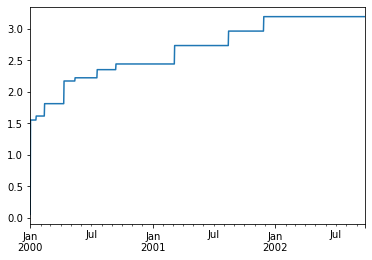

In [21]:
kser = ks.Series(pser)
kser = kser.cummax()
kser.plot()

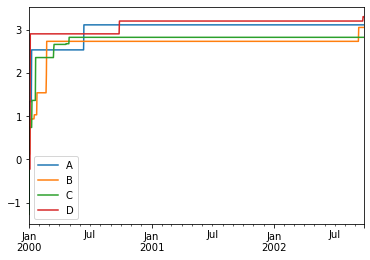

In [22]:
pdf = pd.DataFrame(np.random.randn(1000,4), index=pser.index,
                      columns=['A','B','C','D'])
kdf = ks.from_pandas(pdf)
kdf = kdf.cummax()
kdf.plot()

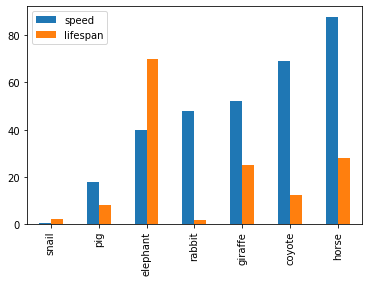

In [34]:
speed = [0.1, 17.5, 40, 48, 52, 69, 88]
lifespan = [2, 8, 70, 1.5, 25, 12, 28]
index = ['snail', 'pig', 'elephant',
          'rabbit', 'giraffe', 'coyote', 'horse']
kdf = ks.DataFrame({'speed': speed,
                     'lifespan': lifespan}, index=index)
kdf.plot.bar()

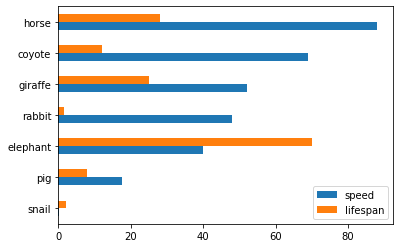

In [35]:
kdf.plot.barh()

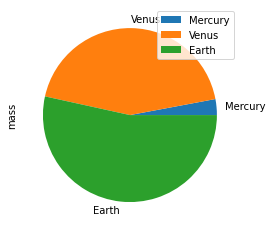

In [36]:
kdf = ks.DataFrame({'mass': [0.330, 4.87, 5.97],
                     'radius': [2439.7, 6051.8, 6378.1]},
                    index=['Mercury', 'Venus', 'Earth'])
 kdf.plot.pie(y='mass')

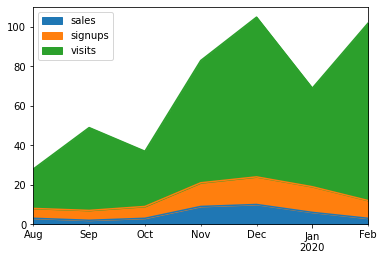

In [37]:
kdf = ks.DataFrame({
     'sales': [3, 2, 3, 9, 10, 6, 3],
     'signups': [5, 5, 6, 12, 14, 13, 9],
     'visits': [20, 42, 28, 62, 81, 50, 90],
 }, index=pd.date_range(start='2019/08/15', end='2020/03/09',
                        freq='M'))
kdf.plot.area()

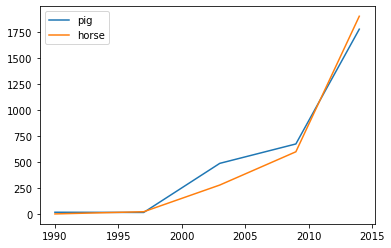

In [38]:
kdf = ks.DataFrame({'pig': [20, 18, 489, 675, 1776],
                     'horse': [4, 25, 281, 600, 1900]},
                    index=[1990, 1997, 2003, 2009, 2014])
kdf.plot.line()

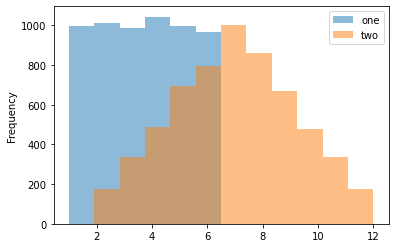

In [39]:
kdf = pd.DataFrame(
     np.random.randint(1, 7, 6000),
     columns=['one'])
kdf['two'] = kdf['one'] + np.random.randint(1, 7, 6000)
kdf = ks.from_pandas(kdf)
kdf.plot.hist(bins=12, alpha=0.5)

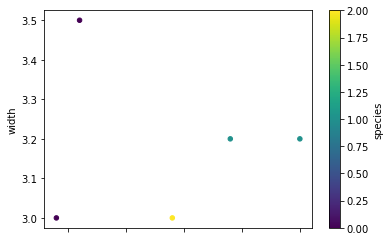

In [40]:
kdf = ks.DataFrame([[5.1, 3.5, 0], [4.9, 3.0, 0], [7.0, 3.2, 1],
                     [6.4, 3.2, 1], [5.9, 3.0, 2]],
                    columns=['length', 'width', 'species'])
kdf.plot.scatter(x='length', y='width', c='species', colormap='viridis')

## Getting data in/out

In [24]:
# csv
kdf.to_csv('output/foo.csv')
ks.read_csv('output/foo.csv').head(10)

,A,B,C,D
0,-1.173088,-0.163375,-1.271145,-0.225697
1,1.337956,0.120648,0.740850,-0.225697
2,1.337956,0.120648,0.740850,-0.225697
3,1.337956,0.930043,0.740850,-0.225697
4,1.337956,0.930043,0.740850,2.907976
5,1.337956,0.930043,0.740850,2.907976
6,1.337956,0.930043,0.740850,2.907976
7,1.337956,0.930043,0.740850,2.907976
8,2.536713,0.930043,0.740850,2.907976
9,2.536713,0.930043,1.366631,2.907976


In [25]:
# parquet
kdf.to_parquet('output/bar.parquet')
ks.read_parquet('output/bar.parquet').head(10)

,A,B,C,D
0,-1.173088,-0.163375,-1.271145,-0.225697
1,1.337956,0.120648,0.740850,-0.225697
2,1.337956,0.120648,0.740850,-0.225697
3,1.337956,0.930043,0.740850,-0.225697
4,1.337956,0.930043,0.740850,2.907976
5,1.337956,0.930043,0.740850,2.907976
6,1.337956,0.930043,0.740850,2.907976
7,1.337956,0.930043,0.740850,2.907976
8,2.536713,0.930043,0.740850,2.907976
9,2.536713,0.930043,1.366631,2.907976


In [26]:
# Spark IO
kdf.to_spark_io('output/zoo.orc', format="orc")
ks.read_spark_io('output/zoo.orc', format="orc").head(10)

,A,B,C,D
0,-1.173088,-0.163375,-1.271145,-0.225697
1,1.337956,0.120648,0.740850,-0.225697
2,1.337956,0.120648,0.740850,-0.225697
3,1.337956,0.930043,0.740850,-0.225697
4,1.337956,0.930043,0.740850,2.907976
5,1.337956,0.930043,0.740850,2.907976
6,1.337956,0.930043,0.740850,2.907976
7,1.337956,0.930043,0.740850,2.907976
8,2.536713,0.930043,0.740850,2.907976
9,2.536713,0.930043,1.366631,2.907976


## Using SQL in Koalas

In [28]:
kdf = ks.DataFrame({'year': [1990, 1997, 2003, 2009, 2014],
                     'pig': [20, 18, 489, 675, 1776],
                     'horse': [4, 25, 281, 600, 1900]})
kdf

,year,pig,horse
0,1990,20,4
1,1997,18,25
2,2003,489,281
3,2009,675,600
4,2014,1776,1900


In [30]:
ks.sql("SELECT year, pig, horse FROM {kdf} WHERE horse > 200")

,year,pig,horse
0,2003,489,281
1,2009,675,600
2,2014,1776,1900


In [32]:
pdf = pd.DataFrame({'year': [1990, 1997, 2003, 2009, 2014],
                     'sheep': [22, 50, 121, 445, 791],
                     'chicken': [250, 326, 589, 1241, 2118]})
pdf

,year,sheep,chicken
0,1990,22,250
1,1997,50,326
2,2003,121,589
3,2009,445,1241
4,2014,791,2118


In [33]:
ks.sql('''
    SELECT ks.pig, pd.chicken
    FROM {kdf} ks INNER JOIN {pdf} pd
    ON ks.year = pd.year
    ORDER BY ks.pig, pd.chicken
''')

,pig,chicken
0,18,326
1,20,250
2,489,589
3,675,1241
4,1776,2118


## Spark Schema

In [42]:
import numpy as np
import pandas as pd
kdf = ks.DataFrame({'a': list('abc'),
                     'b': list(range(1, 4)),
                     'c': np.arange(3, 6).astype('i1'),
                     'd': np.arange(4.0, 7.0, dtype='float64'),
                     'e': [True, False, True],
                     'f': pd.date_range('20130101', periods=3)},
                    columns=['a', 'b', 'c', 'd', 'e', 'f'])

In [46]:
# Print the schema out in Spark’s DDL formatted string
kdf.spark.schema().simpleString()

'struct<a:string,b:bigint,c:tinyint,d:double,e:boolean,f:timestamp>'

In [44]:
kdf.spark.schema(index_col='index').simpleString()

'struct<index:bigint,a:string,b:bigint,c:tinyint,d:double,e:boolean,f:timestamp>'

In [45]:
# Print out the schema as same as Spark’s DataFrame.printSchema()
kdf.spark.print_schema()

root
 |-- a: string (nullable = false)
 |-- b: long (nullable = false)
 |-- c: byte (nullable = false)
 |-- d: double (nullable = false)
 |-- e: boolean (nullable = false)
 |-- f: timestamp (nullable = false)



## Explain Spark Plan

In [47]:
kdf.spark.explain()

== Physical Plan ==
*(1) Scan ExistingRDD[__index_level_0__#1853L,a#1854,b#1855L,c#1856,d#1857,e#1858,f#1859]




In [48]:
kdf.spark.explain(True)

== Parsed Logical Plan ==
Project [__index_level_0__#1853L, a#1854, b#1855L, c#1856, d#1857, e#1858, f#1859]
+- Project [__index_level_0__#1853L, a#1854, b#1855L, c#1856, d#1857, e#1858, f#1859, monotonically_increasing_id() AS __natural_order__#1867L]
   +- LogicalRDD [__index_level_0__#1853L, a#1854, b#1855L, c#1856, d#1857, e#1858, f#1859], false

== Analyzed Logical Plan ==
__index_level_0__: bigint, a: string, b: bigint, c: tinyint, d: double, e: boolean, f: timestamp
Project [__index_level_0__#1853L, a#1854, b#1855L, c#1856, d#1857, e#1858, f#1859]
+- Project [__index_level_0__#1853L, a#1854, b#1855L, c#1856, d#1857, e#1858, f#1859, monotonically_increasing_id() AS __natural_order__#1867L]
   +- LogicalRDD [__index_level_0__#1853L, a#1854, b#1855L, c#1856, d#1857, e#1858, f#1859], false

== Optimized Logical Plan ==
LogicalRDD [__index_level_0__#1853L, a#1854, b#1855L, c#1856, d#1857, e#1858, f#1859], false

== Physical Plan ==
*(1) Scan ExistingRDD[__index_level_0__#1853L,a#1854

In [50]:
kdf.spark.explain(mode="extended")

== Parsed Logical Plan ==
Project [__index_level_0__#1853L, a#1854, b#1855L, c#1856, d#1857, e#1858, f#1859]
+- Project [__index_level_0__#1853L, a#1854, b#1855L, c#1856, d#1857, e#1858, f#1859, monotonically_increasing_id() AS __natural_order__#1867L]
   +- LogicalRDD [__index_level_0__#1853L, a#1854, b#1855L, c#1856, d#1857, e#1858, f#1859], false

== Analyzed Logical Plan ==
__index_level_0__: bigint, a: string, b: bigint, c: tinyint, d: double, e: boolean, f: timestamp
Project [__index_level_0__#1853L, a#1854, b#1855L, c#1856, d#1857, e#1858, f#1859]
+- Project [__index_level_0__#1853L, a#1854, b#1855L, c#1856, d#1857, e#1858, f#1859, monotonically_increasing_id() AS __natural_order__#1867L]
   +- LogicalRDD [__index_level_0__#1853L, a#1854, b#1855L, c#1856, d#1857, e#1858, f#1859], false

== Optimized Logical Plan ==
LogicalRDD [__index_level_0__#1853L, a#1854, b#1855L, c#1856, d#1857, e#1858, f#1859], false

== Physical Plan ==
*(1) Scan ExistingRDD[__index_level_0__#1853L,a#1854